# Imbalanced Data
This notebook contains code examples for some of the methods used to handle imbalanced data sets.
Most code is based on the [Imbalanced-Learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) library.
The notebook only contains a small part of the different sampling available as part of the library.
<br> feel free to checkout the [Github repository](https://github.com/scikit-learn-contrib/imbalanced-learn) for more.

In [1]:
import numpy as np
import pandas as pd
import plotly as plt
from collections import Counter
from sklearn.decomposition import PCA
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

## An Imbalanced Example

Let’s suppose that we have two classes: C0 and C1. Suppose also that in our problem the class C0 represent 90% of the dataset (and, so, the class C1 represent the remaining 10%). <br>
We will generate 50 data points following the above distribution and explore a few different sampling techniques that are meant to help deal with this imbalance.
<br><br>
Let's first import the imbalnced learn library: 

In [2]:
import imblearn

Let's create a small unbalanced sample dataset using the `make_classification` method

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=50, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target = df.target.astype(str)
class_map = {'0':'C0','1':'C1'}
df['target'] = df['target'].map(class_map)
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, `plot_2d_space`, to visualize the data distribution:

In [4]:
def plot_2d_space(X, y, colors=['#0D76BF', '#00cc96'],title=''):
    data = []

    for name, col in zip(np.unique(y), colors):

        trace = dict(
            type='scatter',
            x=X[y==name,0],
            y=X[y==name,1],
            mode='markers',
            name=str(name),
            marker=dict(
                color=col,
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
                opacity=0.4)
        )
        data.append(trace)

    layout = dict(
            title=title,
            xaxis=dict(title='PC1', showline=False),
            yaxis=dict(title='PC2', showline=False)
    )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='pca-scikitlearn')

Since the dataset has many dimensions (features) and we want to be able to explore the reults in a graphic manner, <br>we will reduce the dimensionality of the dataset using Principal Component Analysis (PCA):

In [5]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)

In [6]:
plot_2d_space(X_PCA,df.target.values,title='PCA 2 Dimensions')

## Random under-sampling and over-sampling with imbalanced-learn
Altough these are simplistic approaches I would start with them since they often provide good results with the advantage of a quick run time compared to some of the more complex approaches, especially for high dimensional datasets.

In [7]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_PCA, y=df['target'])


plot_2d_space(X_rus, y_rus, title='Random under-sampling')

In [8]:
print('Resampled dataset shape %s' % Counter(y_rus))

Resampled dataset shape Counter({'C0': 5, 'C1': 5})


In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_PCA, y=df['target'])

print(X_ros.shape[0] - X_PCA.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, title='Random over-sampling')

40 new random picked points


In [10]:
print('Resampled dataset shape %s' % Counter(y_ros))

Resampled dataset shape Counter({'C0': 45, 'C1': 45})


We can see that we now have 45 points for each class. We don't see more points from the minority class since they are overlapping (notice the opacity).

## Under-sampling: Tomek links
Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.
<br>
**a Tomek’s link exist if the two samples are the nearest neighbors of each other**
<br>
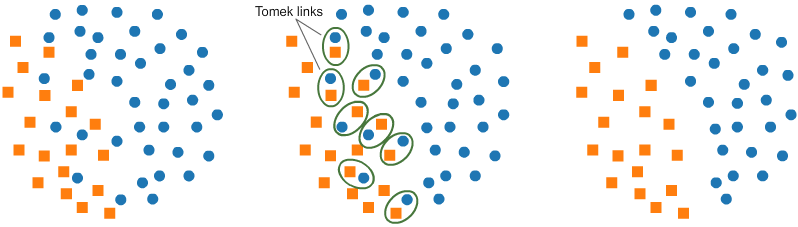

we'll use ratio='majority' to resample the majority class

In [11]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, sampling_strategy='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X_PCA, y=df['target'])

plot_2d_space(X_tl, y_tl, title='Tomek links under-sampling')

In [12]:
print('Resampled dataset shape %s' % Counter(y_tl))

Resampled dataset shape Counter({'C0': 44, 'C1': 5})


## Under-sampling: Cluster Centroids
This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

In this example we will pass the {0: 10} dict for the parameter ratio, to preserve 10 elements from the majority class (0), and all minority class (1).

In [13]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={'C0': 10})
X_cc, y_cc = cc.fit_sample(X_PCA, y=df['target'])

plot_2d_space(X_cc, y_cc, title='Cluster Centroids under-sampling')

In [14]:
print('Resampled dataset shape %s' % Counter(y_cc))

Resampled dataset shape Counter({'C0': 10, 'C1': 5})


## Over-sampling: SMOTE
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the n-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
<br>

### What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the neighbors an generates random points on the lines. Then create samples on the lines with class == minority class.
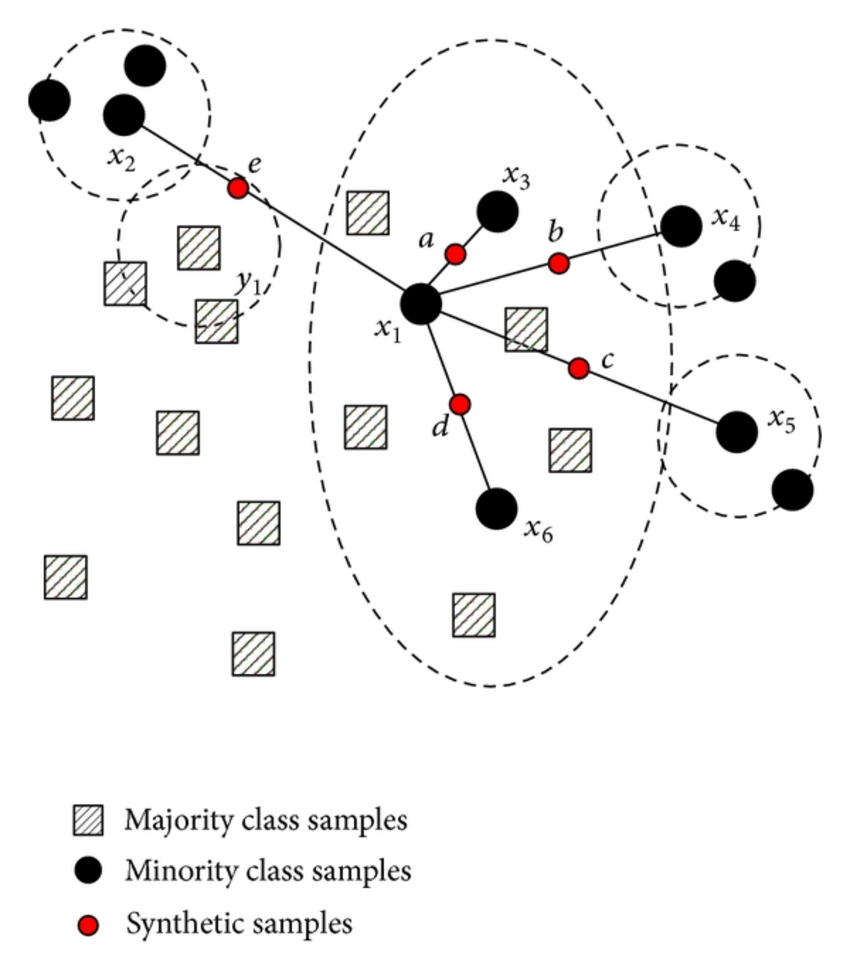 

We'll use ratio='minority' to resample the minority class.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={'C1': 10},k_neighbors=4)
X_sm, y_sm = smote.fit_sample(X_PCA, y=df['target'])

plot_2d_space(X_sm, y_sm, title = 'SMOTE over-sampling')

In [16]:
print('Resampled dataset shape %s' % Counter(y_sm))

Resampled dataset shape Counter({'C0': 45, 'C1': 10})


## Over-sampling: ADASYN
Adaptive Synthetic Sampling - improved version of SMOTE. What it does is same as SMOTE just with a minor improvement. After creating those sample it adds a random small values to the points thus making it more realistic. In other words instead of all the sample being linearly correlated to the parent they have a little more variance

In [17]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(sampling_strategy={'C1': 10}, n_neighbors=4)
X_adasyn, y_adasyn = ada.fit_resample(X_PCA, y=df['target'])

plot_2d_space(X_adasyn, y_adasyn, title='ADASYN - Adaptive Synthetic Sampling')

In [18]:
print('Resampled dataset shape %s' % Counter(y_adasyn))

Resampled dataset shape Counter({'C0': 45, 'C1': 10})


### The key idea of ADASYN algorithm is to use a density distribution as a criterion to automatically decide the number of synthetic samples that need to be generated for each minority data example. 
<br>Physically, this measurement is a measurement of the distribution of weights for different minority class examples according to their level of difficulty in learning. The resulting dataset post ADASYN will not only provide a balanced representation of the data distribution, but it will also **force the learning algorithm to focus on those difficult to learn examples**. 
<br>
This is a major difference compared to the SMOTE algorithm, in which equal numbers of syntheticsamples are generated for each minority data example.

## Over-sampling followed by under-sampling
Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

In [19]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto',smote = SMOTE(sampling_strategy={'C1': 10},k_neighbors=4),
                 tomek=TomekLinks())
X_smt, y_smt = smt.fit_sample(X_PCA, y=df['target'])

plot_2d_space(X_smt, y_smt, title='SMOTE + Tomek links')

In [20]:
print('Resampled dataset shape %s' % Counter(y_smt))

Resampled dataset shape Counter({'C0': 43, 'C1': 10})


## Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC)
When dealing with a mixed of continuous and categorical features it is possible to use SMOTE-NC.
<br>Here I define a dataset containing 30 samples with 2 categorical features (The first and last columns contain categorical features). Initially there are 10 samples for the minority class and 20 samples for the majority class.
<br>Then, I use **SMOTE-NC** to generate synthetic examples:

In [21]:
from imblearn.over_sampling import SMOTENC
from numpy.random import RandomState

rng = np.random.RandomState(13)
n_samples = 30
X_SMOTE_NC = np.empty((n_samples, 3), dtype=object)
X_SMOTE_NC[:, 0] = rng.choice(['A', 'B', 'C'], size=n_samples).astype(object)
X_SMOTE_NC[:, 1] = rng.randn(n_samples)
X_SMOTE_NC[:, 2] = rng.randint(3, size=n_samples)
y_smote_nc = np.array([0] * 10 + [1] * 20)

print('The original imbalanced dataset proportions:')
print(sorted(Counter(y_smote_nc).items()))

smote_nc = SMOTENC(categorical_features=[0, 2], random_state=13)
X_resampled, y_resampled = smote_nc.fit_resample(X_SMOTE_NC, y_smote_nc)
print('Dataset proportions after resampling:')
print(sorted(Counter(y_resampled).items()))
print('SMOTE-NC will generate categories for the categorical features')


The original imbalanced dataset proportions:
[(0, 10), (1, 20)]
Dataset proportions after resampling:
[(0, 20), (1, 20)]
SMOTE-NC will generate categories for the categorical features


As we can see SMOTE-NC generated 10 synthtic examples, taking into account the categorical features:

In [23]:
side_by_side = (pd.DataFrame(X_resampled))
side_by_side.join(pd.DataFrame(X_SMOTE_NC),rsuffix='_original',lsuffix='_SMOTE_NC')[20:]

,0_SMOTE_NC,1_SMOTE_NC,2_SMOTE_NC,0_original,1_original,2_original
20,A,-0.62098,0,A,-0.62098,0
21,C,-0.453752,2,C,-0.453752,2
22,A,0.217452,2,A,0.217452,2
23,B,0.514329,1,B,0.514329,1
24,C,0.397241,0,C,0.397241,0
25,B,-1.51285,1,B,-1.51285,1
26,B,-0.764034,0,B,-0.764034,0
27,C,0.10127,0,C,0.10127,0
28,A,-0.317266,1,A,-0.317266,1
29,A,1.13833,0,A,1.13833,0


<div class="alert alert-block alert-warning">
<b>Remember!</b> <br>There is no *Good* or *Bad* here. No technique is necessarily better than the other. Different techniques might prove useful for different problems. It is very much dependent on your data as well as on what is the task at hand.
</div>